In [2]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain

In [26]:
#Reference Population
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100)]
Ne = 100
recomb = 0.1
ts_ref = msprime.simulate(
    population_configurations=pop_configs,Ne = Ne,mutation_rate=0.25,recombination_rate = recomb,random_seed=11)
print(ts_ref.num_mutations)
print(ts_ref.segregating_sites())

500
500.0


In [16]:
#ABC Function
def ABC_regression(data,eps,pop_configs,Ne,recomb,prior="exponential",prior_parameters=1,iters=1000):
    ref_stat = (data.diversity(),data.Tajimas_D(),data.segregating_sites())
    samples = []
    discrepancies = []
    if prior == "exponential":
        for i in range(0,iters):
            mutation_rate_sim = np.random.exponential(prior_parameters)
            ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=mutation_rate_sim)
            sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
            if np.linalg.norm(np.subtract(sim_stat,ref_stat)) < eps:
                samples.append(mutation_rate_sim)
                discrepancies.append(np.subtract(sim_stat,ref_stat))
    elif prior == "uniform":
        for i in range(0,iters):
            mutation_rate_sim = np.random.uniform(prior_parameters[0],prior_parameters[1])
            ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=mutation_rate_sim)
            sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
            if np.linalg.norm(np.subtract(ref_stat,sim_stat)) < eps:
                samples.append(mutation_rate_sim)
    elif prior == "gamma":
        for i in range(0,iters):
            mutation_rate_sim = np.random.gamma(prior_parameters[0],prior_parameters[1])
            ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=mutation_rate_sim)
            sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
            if np.linalg.norm(np.subtract(sim_stat,ref_stat)) < eps:
                samples.append(mutation_rate_sim)
    return(samples,discrepancies)

In [17]:
%%time
#Exponential prior scale 0.2
iterations = 100000
eps = 10
prior= "exponential"
prior_parameters = 0.2
attempt1 = ABC_regression(ts_ref,eps=eps,pop_configs=pop_configs,Ne=Ne,recomb=recomb,prior=prior,prior_parameters=prior_parameters,iters=iterations)

Wall time: 7min 38s


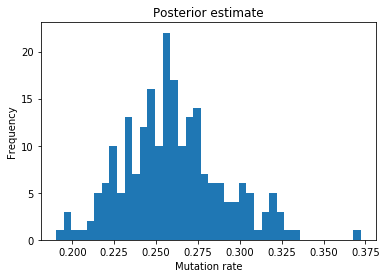

Acceptance probability : 0.00221
221


In [27]:
plt.hist(attempt1[0], bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt1[0])/iterations)
print(len(attempt1[0]))

In [42]:
X = np.zeros((len(attempt1[0]),4))
for i in range(len(attempt1[0])):
    for j in range(4):
        if j == 0:
            X[i][j]=1
        else:
            X[i][j]= attempt1[1][i][j-1]
adjusted_samples = np.subtract(attempt1[0],np.dot(np.array(attempt1[1]),np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,np.array(attempt1[0])))[1:]))


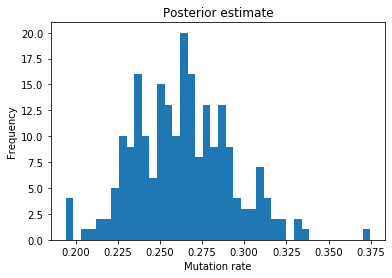

Acceptance probability : 0.00221
221


In [43]:
plt.hist(adjusted_samples, bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt1[0])/iterations)
print(len(attempt1[0]))